In [1]:
!unzip Equivariant_QCNN.zip

Archive:  Equivariant_QCNN.zip
   creating: Equivariant_QCNN/
   creating: Equivariant_QCNN/Result/
  inflating: Equivariant_QCNN/Result/.DS_Store  
   creating: Equivariant_QCNN/Result/Data/
  inflating: Equivariant_QCNN/Result/Data/.DS_Store  
  inflating: Equivariant_QCNN/Result/Data/.DS_StoreZone.Identifier  
   creating: Equivariant_QCNN/Result/Data/CNN/
  inflating: Equivariant_QCNN/Result/Data/CNN/CNN_result.py  
  inflating: Equivariant_QCNN/Result/Data/CNN/CNN_result.pyZone.Identifier  
   creating: Equivariant_QCNN/Result/Data/CNN/loss history/
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L.txt  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L.txtZone.Identifier  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L_DATA2.txt  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L_DATA2.txtZone.Identifier  
  inflating: Equivariant_QCNN/Result/Data/CNN

In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00


In [3]:
import sys
import os

# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('./')))

import numpy as np
# from Equivariant_QCNN.data.data import data_load_and_process
from Equivariant_QCNN.training.Training import circuit_training
from Equivariant_QCNN.models.QCNN_circuit import QCNN
import matplotlib.pyplot as plt
from Equivariant_QCNN.benchmarking.Benchmarking import accuracy_test, round_predictions_f
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:


# Loads and Processes the data that will be used in QCNN and Hierarchical Classifier Training

import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import h5py

def data_load_and_process(dataset, classes=[0, 1], feature_reduction="img16x16x1", binary=True):
    print(f"Function called with: dataset={dataset}, classes={classes}, feature_reduction={feature_reduction}, binary={binary}")

    X_train, X_test, Y_train, Y_test = None, None, [], []

    try:
        if dataset == 'fashion_mnist':
            print("Loading fashion_mnist dataset")
            (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
            x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
            X_train, X_test, Y_train, Y_test = x_train, x_test, y_train, y_test

        elif dataset == 'mnist':
            print("Loading mnist dataset")
            (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
            x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
            X_train, X_test, Y_train, Y_test = x_train, x_test, y_train, y_test

        elif dataset == "quark_gluon":
            print("Loading quark_gluon dataset")
            QG_path = "/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP/Equivariant_QCNN/data/Q-G_resize/QG-bilinear-ECAL-(16, 16, 1).h5py"
            with h5py.File(QG_path, "r") as file:
                X = np.array(file["X"])
                y = np.array(file["y"])

            X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

            X_train, Y_train = X_train[:20000], Y_train[:20000]
            X_test, Y_test = X_test[:5000], Y_test[:5000]

        elif dataset == "electron_photon":
            print("Loading electron_photon dataset")
            path_ep = "/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP/Equivariant_QCNN/data/E-P_rescaled"
            with h5py.File(path_ep, "r") as file:
                X_ep = np.array(file["X"])
                y_ep = np.array(file["y"])

            X_train, X_test, Y_train, Y_test = train_test_split(X_ep, y_ep, test_size=0.2, random_state=42, stratify=y_ep)
            X_train, Y_train = X_train[:20000], Y_train[:20000]
            X_test, Y_test = X_test[:5000], Y_test[:5000]

        else:
            raise ValueError(f"Invalid dataset: {dataset}")

        print(f"After dataset loading: X_train shape: {X_train.shape if X_train is not None else None}, "
              f"Y_train shape: {Y_train.shape if isinstance(Y_train, np.ndarray) else len(Y_train)}")

        # Process classes
        print(f"Processing classes: {classes}")
        if classes == 'odd_even':
            odd = [1, 3, 5, 7, 9]
            Y_train = [1 if y in odd else (-1 if binary else 0) for y in Y_train]
            Y_test = [1 if y in odd else (-1 if binary else 0) for y in Y_test]

        elif classes == '>4':
            greater = [5, 6, 7, 8, 9]
            Y_train = [1 if y in greater else (-1 if binary else 0) for y in Y_train]
            Y_test = [1 if y in greater else (-1 if binary else 0) for y in Y_test]

        elif isinstance(classes, list) and len(classes) == 2:
            if dataset not in ["quark_gluon", "electron_photon"]:
                x_train_filter_01 = np.where((Y_train == classes[0]) | (Y_train == classes[1]))
                x_test_filter_01 = np.where((Y_test == classes[0]) | (Y_test == classes[1]))

                X_train, X_test = X_train[x_train_filter_01], X_test[x_test_filter_01]
                Y_train, Y_test = Y_train[x_train_filter_01], Y_test[x_test_filter_01]

            Y_train = [1 if y == classes[0] else (-1 if binary else 0) for y in Y_train]
            Y_test = [1 if y == classes[0] else (-1 if binary else 0) for y in Y_test]
        else:
            raise ValueError(f"Invalid classes parameter: {classes}")

        print(f"After class processing: Y_train length: {len(Y_train)}, Y_test length: {len(Y_test)}")

        # Feature reduction
        print(f"Applying feature reduction: {feature_reduction}")
        if feature_reduction == 'img16x16x1':
            X_train = tf.image.resize(X_train, (16, 16)).numpy()
            X_test = tf.image.resize(X_test, (16, 16)).numpy()
            X_train = np.squeeze(np.expand_dims(X_train, axis=-1), axis=-1)
            X_test = np.squeeze(np.expand_dims(X_test, axis=-1), axis=-1)

        elif feature_reduction == 'resize256':
            X_train = tf.squeeze(tf.image.resize(X_train, (256, 1))).numpy()
            X_test = tf.squeeze(tf.image.resize(X_test, (256, 1))).numpy()

        elif feature_reduction == 'pca8':
            X_train = tf.squeeze(tf.image.resize(X_train, (X_train.shape[1]*X_train.shape[1], 1))).numpy()
            X_test = tf.squeeze(tf.image.resize(X_test, (X_test.shape[1]*X_test.shape[1], 1))).numpy()

            pca = PCA(8)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            # Rescale for angle embedding
            X_train = (X_train - X_train.min()) * (np.pi / (X_train.max() - X_train.min()))
            X_test = (X_test - X_test.min()) * (np.pi / (X_test.max() - X_test.min()))
        else:
            raise ValueError(f"Invalid feature_reduction parameter: {feature_reduction}")

        print(f"Final shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, "
              f"Y_train length: {len(Y_train)}, Y_test length: {len(Y_test)}")

        return X_train, X_test, Y_train, Y_test

    except Exception as e:
        print(f"Error in data_load_and_process: {str(e)}")
        print(f"Dataset: {dataset}, Classes: {classes}, Feature Reduction: {feature_reduction}, Binary: {binary}")
        print(f"X_train shape: {X_train.shape if X_train is not None else None}")
        print(f"X_test shape: {X_test.shape if X_test is not None else None}")
        print(f"Y_train length: {len(Y_train)}")
        print(f"Y_test length: {len(Y_test)}")
        raise


In [14]:
"""
Here are possible combinations of benchmarking user could try.
Unitaries: ['U_TTN', 'U2_equiv', 'U4_equiv', 'U_5', 'U_6', 'U_9', 'U_13', 'U_14', 'U_15', 'U_SO4', 'U_SU4', 'U_SU4_no_pooling', 'U_SU4_1D', 'U_9_1D']
U_num_params: [2, 6, 6, 10, 10, 2, 6, 6, 4, 6, 15, 15, 15, 2]
feature_reduction: ['img16x16x1','resize256', 'pca8']
embedding_type: ["Equivariant-Amplitude", "Amplitude", "Angle"]
dataset: 'mnist' or 'fashion_mnist'
circuit: 'QCNN'
cost_fn: 'mse' or 'cross_entropy'
Note: when using 'mse' as cost_fn binary="True" is recommended, when using 'cross_entropy' as cost_fn must be binary="False".
"""


# invariant testings

# U2_equiv is invariant under p4m using MSE
# U2_equiv is invariant under reflections over X using cross_entropy


params = np.random.random(22)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
circuit = "QCNN"
cost_fn = "mse"
binary = True
dataset = "mnist"


X_train, X_test, Y_train, Y_test = data_load_and_process( dataset, [0,1], "img16x16x1", binary)

print(X_train.shape)

Function called with: dataset=mnist, classes=[0, 1], feature_reduction=img16x16x1, binary=True
Loading mnist dataset
After dataset loading: X_train shape: (60000, 28, 28, 1), Y_train shape: (60000,)
Processing classes: [0, 1]
After class processing: Y_train length: 12665, Y_test length: 2115
Applying feature reduction: img16x16x1
Final shapes: X_train: (12665, 16, 16, 1), X_test: (2115, 16, 16, 1), Y_train length: 12665, Y_test length: 2115
(12665, 16, 16, 1)


In [15]:
import sys
import os
import csv
import time
from datetime import datetime

# Existing imports
import Equivariant_QCNN.models.QCNN_circuit as QCNN_circuit
import pennylane as qml
from pennylane import numpy as np
import autograd.numpy as anp
from Equivariant_QCNN.benchmarking.Benchmarking import accuracy_test


# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('./')))


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy
    return -1 * loss

def cost(params, X, Y, U, U_params, embedding_type, circuit, cost_fn):
    if circuit == 'QCNN':
        predictions = [QCNN_circuit.QCNN(x, params, U, U_params, embedding_type, cost_fn=cost_fn) for x in X]

    if cost_fn == 'mse':
        loss = square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        loss = cross_entropy(Y, predictions)
    return loss

# Existing functions (square_loss, cross_entropy, cost) remain unchanged

def circuit_training(X_train, Y_train, U, U_params, embedding_type, layers, circuit, cost_fn, params, opt_type="Adam", steps=50, initial_learning_rate=0.01, batch_size=128, decay_factor=0.5, decay_steps=10):
    opt_classes = {
        "Adam": qml.AdamOptimizer(stepsize=initial_learning_rate),
        "Nesterov": qml.NesterovMomentumOptimizer(stepsize=initial_learning_rate)
    }

    opt = opt_classes[opt_type]

    loss_history = []
    train_acc_history = []

    start_time = time.time()

    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, embedding_type, circuit, cost_fn), params)
        loss_history.append(cost_new)

        predictions = [QCNN_circuit.QCNN(x, params, U, U_params, embedding_type, cost_fn, layers) for x in X_train[batch_size:batch_size*5]]

        accuracy = accuracy_test(predictions, Y_train[batch_size:batch_size*5], cost_fn, cost_fn == "mse")
        train_acc_history.append(accuracy)

        if it % 1 == 0:
            print("iteration: ", it, " cost: ", cost_new, "train_accuracy:", accuracy)

        if (it + 1) % decay_steps == 0:
            learning_rate = initial_learning_rate * decay_factor
            opt_classes = {
                "Adam": qml.AdamOptimizer(stepsize=learning_rate),
                "Nesterov": qml.NesterovMomentumOptimizer(stepsize=learning_rate)
            }
            opt = opt_classes[opt_type]
            print(f"Learning rate reduced to: {learning_rate}")

    training_time = time.time() - start_time

    metrics = {
        'Optimizer': opt_type,
        'Learning_Rate': initial_learning_rate,
        'Batch_Size': batch_size,
        'Epochs': steps,
        'Loss_Function': cost_fn,
        'Training_Time': f"{training_time:.2f}",
        'Final_Train_Accuracy': f"{train_acc_history[-1]:.2f}"
    }

    return loss_history, train_acc_history, params, metrics

def run_quantum_circuit_experiment(params, U_params, U, embedding_type, feature_reduction, circuit, cost_fn, binary, dataset, opt_type="Adam", steps=50, initial_learning_rate=0.01, batch_size=128, decay_factor=0.5, decay_steps=10):
    # Load and process data
    X_train, X_test, Y_train, Y_test = data_load_and_process(
        dataset, classes=[0, 1], feature_reduction=feature_reduction, binary=binary
    )

    # Define layers (you might want to adjust this based on your specific requirements)
    layers = 2  # Assuming 2 layers, adjust as needed

    # Training
    loss_history, train_acc_history, updated_params, train_metrics = circuit_training(
        X_train, Y_train, U, U_params, embedding_type, layers, circuit, cost_fn,
        params, opt_type, steps, initial_learning_rate, batch_size, decay_factor, decay_steps
    )

    # Testing
    start_time = time.time()
    test_predictions = [QCNN_circuit.QCNN(x, updated_params, U, U_params, embedding_type, cost_fn, layers) for x in X_test]
    inference_time = time.time() - start_time

    test_accuracy = accuracy_test(test_predictions, Y_test, cost_fn, cost_fn == "mse")

    # Combine metrics
    metrics = {
        **train_metrics,
        'Inference_Time': f"{inference_time:.2f}",
        'Final_Test_Accuracy': f"{test_accuracy:.2f}",
        'Training_Subset_Size': f"{len(X_train)} samples",
        'U_params': U_params,
        'U': U,
        'Embedding_Type': embedding_type,
        'Feature_Reduction': feature_reduction,
        'Circuit': circuit,
        'Cost_Function': cost_fn,
        'Binary': binary,
        'Dataset': dataset
    }

    # Write metrics to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f'quantum_circuit_metrics_{dataset}_{timestamp}.csv'
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
        writer.writeheader()
        writer.writerow(metrics)

    print(f"Metrics have been saved to {csv_filename}")

    return loss_history, train_acc_history, updated_params, metrics



In [18]:

# Usage example with pre-defined variables:
params = np.random.random(200)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
feature_reduction = "img16x16x1"
circuit = "QCNN"
cost_fn = "mse"
binary = True
dataset = "mnist"

loss_history, train_acc_history, final_params, metrics = run_quantum_circuit_experiment(
    params, U_params, U, embedding_type, feature_reduction, circuit, cost_fn, binary, dataset,
    opt_type="Adam", steps=50, initial_learning_rate=0.01, batch_size=128, decay_factor=0.5, decay_steps=10
)

print("Experiment completed. Final metrics:", metrics)

Function called with: dataset=mnist, classes=[0, 1], feature_reduction=img16x16x1, binary=True
Loading mnist dataset
After dataset loading: X_train shape: (60000, 28, 28, 1), Y_train shape: (60000,)
Processing classes: [0, 1]
After class processing: Y_train length: 12665, Y_test length: 2115
Applying feature reduction: img16x16x1
Final shapes: X_train: (12665, 16, 16, 1), X_test: (2115, 16, 16, 1), Y_train length: 12665, Y_test length: 2115
iteration:  0  cost:  1.0144798128935169 train_accuracy: 0.892578125
iteration:  1  cost:  0.9906168802818248 train_accuracy: 0.916015625
iteration:  2  cost:  0.9556484535360041 train_accuracy: 0.9296875
iteration:  3  cost:  0.9330696298969993 train_accuracy: 0.91796875
iteration:  4  cost:  0.9427720772685562 train_accuracy: 0.927734375
iteration:  5  cost:  0.9292915642082442 train_accuracy: 0.935546875
iteration:  6  cost:  0.9052862888394838 train_accuracy: 0.9375
iteration:  7  cost:  0.8901942876717878 train_accuracy: 0.94140625
iteration:  

 Output with Probabilities for Original Image: -0.02641627771842741
 Output with Probabilities for Image Reflected over Y-axis: -0.026416277718427413
 Output with Probabilities for Image Reflected over X-axis: -0.026416277718427424
 Output with Probabilities for Image Rotated 90 Degrees: -0.026416277718427243


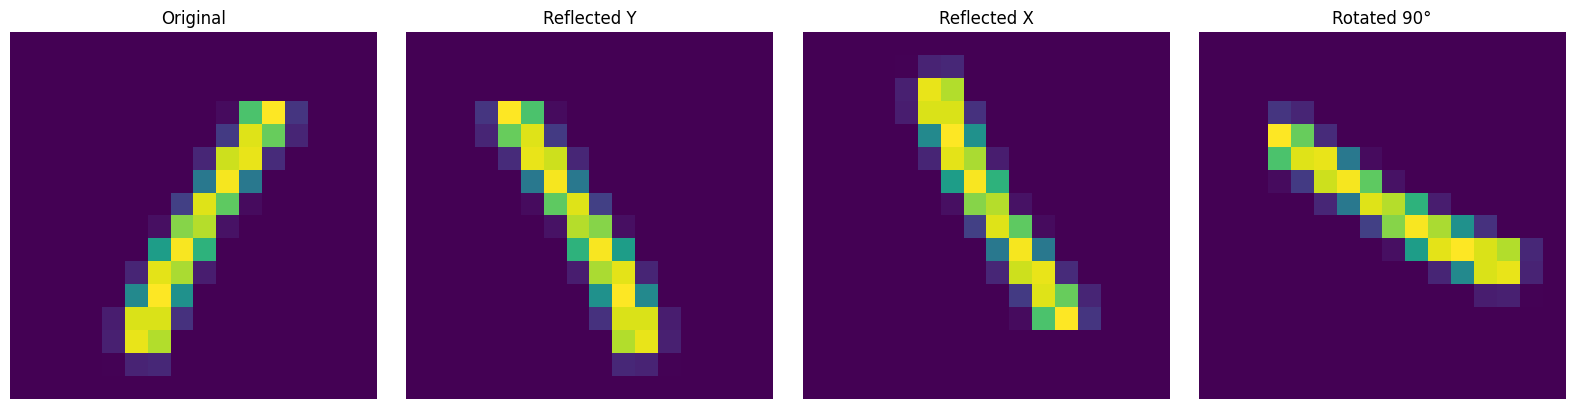

In [8]:
#data and transformed data
matrix = np.array(X_train[1])
matrix_reflected_y = np.fliplr(matrix) # Image Reflected over Y-axis
matrix_reflected_x = np.flipud(matrix) # Image Reflected over X-axis
matrix_rotated_90 = np.rot90(matrix) # Image rotated 90 degrees


result1 = QCNN(matrix, params, U, U_params, embedding_type, cost_fn)
result2 = QCNN(matrix_reflected_y, params,U, U_params, embedding_type, cost_fn)
result3 = QCNN(matrix_reflected_x, params, U, U_params, embedding_type, cost_fn)
result4 = QCNN(matrix_rotated_90, params, U, U_params, embedding_type, cost_fn)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(matrix)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Reflected Y')
plt.imshow(matrix_reflected_y)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Reflected X')
plt.imshow(matrix_reflected_x)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Rotated 90°')
plt.imshow(matrix_rotated_90)
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# predictions = [QCNN(x, params, U, U_params, embedding_type, cost_fn) for x in X_test]

# accuracy = accuracy_test(predictions, Y_test, cost_fn, binary)
# accuracy

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-3bbc10d1bae6>", line 1, in <cell line: 1>
    predictions = [QCNN(x, params, U, U_params, embedding_type, cost_fn) for x in X_test]
  File "<ipython-input-9-3bbc10d1bae6>", line 1, in <listcomp>
    predictions = [QCNN(x, params, U, U_params, embedding_type, cost_fn) for x in X_test]
  File "/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py", line 1020, in __call__
    return self._impl_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py", line 1008, in _impl_call
    res = self._execution_component(args, kwargs, override_shots=override_shots)
  File "/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py", line 957, in _execution_component
    res = qml.execute(
  File "/usr/local/lib/python3.

TypeError: object of type 'NoneType' has no len()

In [ ]:
# round_predictions = round_predictions_f(predictions, cost_fn)

# cm = confusion_matrix(Y_test, round_predictions)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()